In [1]:
import tqdm
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

import librosa, librosa.display

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### READ AND CONCAT DATA ###

label = pd.read_csv('profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']

data = ['PS1.txt','PS2.txt','PS3.txt','PS4.txt','PS5.txt','PS6.txt']
df = pd.DataFrame()

for txt in data:
    read_df = pd.read_csv(txt, sep='\t', header=None)
    df = df.append(read_df)

print(df.shape)
df.head()

(13230, 6000)


,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,151.47,151.45,151.52,151.27,150.80,150.69,153.89,154.67,152.88,153.82,...,151.16,151.19,151.25,151.16,151.10,151.16,151.14,151.10,151.21,151.19
1,151.11,151.12,151.16,150.92,150.70,150.62,152.40,153.21,152.81,153.53,...,150.82,150.82,150.86,150.80,150.73,150.79,150.84,150.79,150.80,150.86
2,150.81,150.79,150.84,150.65,150.35,150.23,152.03,152.81,152.44,153.27,...,150.49,150.44,150.47,150.46,150.38,150.47,150.50,150.43,150.54,150.62
3,150.48,150.47,150.52,150.31,150.04,149.98,151.63,152.48,152.24,152.94,...,150.34,150.30,150.28,150.38,150.41,150.33,150.31,150.31,150.25,150.28
4,150.41,150.35,150.24,150.12,149.87,149.71,151.64,152.37,151.78,152.68,...,150.31,150.20,150.17,150.28,150.31,150.25,150.27,150.22,150.13,150.19


In [4]:
### RESHAPE DATA AMONG SENSORS ###

df = df.sort_index().values.reshape(-1,len(data),len(df.columns)).transpose(0,2,1)
df.shape

(2205, 6000, 6)

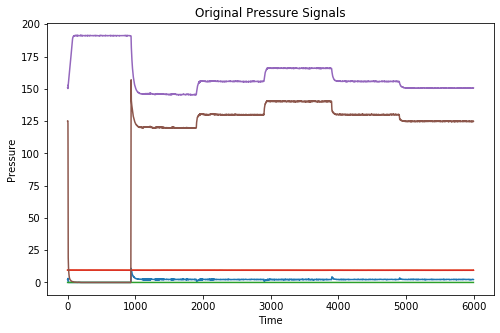

In [5]:
### PLOT ORIGINAL PRESSURE DATA ###

plt.figure(figsize=(8,5))
plt.plot(df[2])
plt.title('Original Pressure Signals')
plt.ylabel('Pressure'); plt.xlabel('Time')
np.set_printoptions(False)

In [6]:
### APPLY CLIPPING AND FIRST ORDER DIFFERECE ###

df = np.clip(np.diff(df, axis=1), -5,5)
df.shape

(2205, 5999, 6)

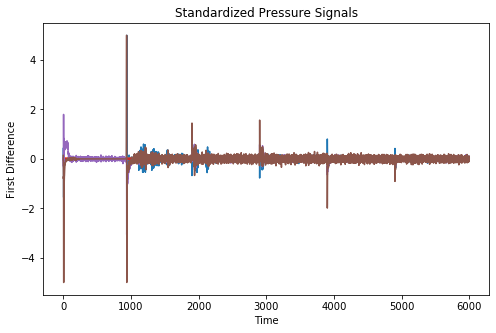

In [7]:
### PLOT STANDARDIZED DATA ###

plt.figure(figsize=(8,5))
plt.plot(df[2])
plt.title('Standardized Pressure Signals')
plt.ylabel('First Difference'); plt.xlabel('Time')
np.set_printoptions(False)

In [8]:
### LABEL DISTRIBUTION ###

label = label.Accumulator
label.value_counts()

90     808
130    599
115    399
100    399
Name: Accumulator, dtype: int64

In [9]:
### MAPPING LABEL ###

diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = to_categorical(label)

{130: 0, 115: 1, 100: 2, 90: 3}
{0: 130, 1: 115, 2: 100, 3: 90}


In [10]:
### APPLY SPECTROGRAM TRANSFORMATION FOR EACH PRESSURE SIGNAL ###

df_spectre = []

for i,sample in enumerate(tqdm.tqdm(df)):
    
    sample_spectre = np.apply_along_axis(lambda x: librosa.feature.melspectrogram(x,sr=40000) ,0, sample)
    df_spectre.append(sample_spectre)
    
df_spectre = np.asarray(df_spectre)
df_spectre.shape

100%|██████████████████████████████████████████████████████████████████████████████| 2205/2205 [01:50<00:00, 19.91it/s]


(2205, 128, 12, 6)

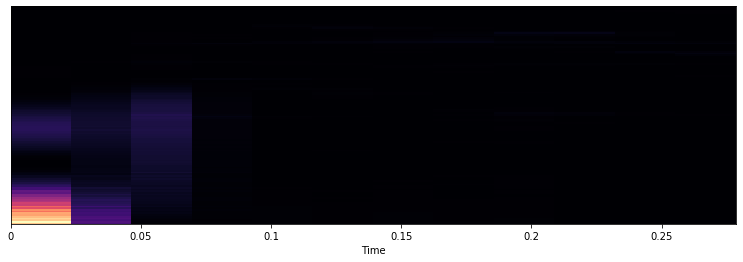

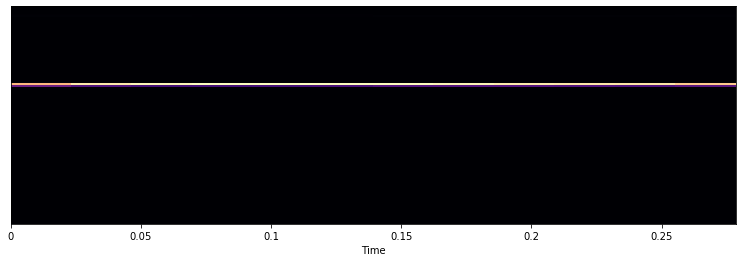

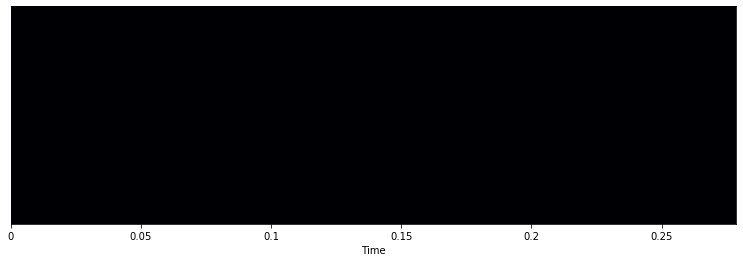

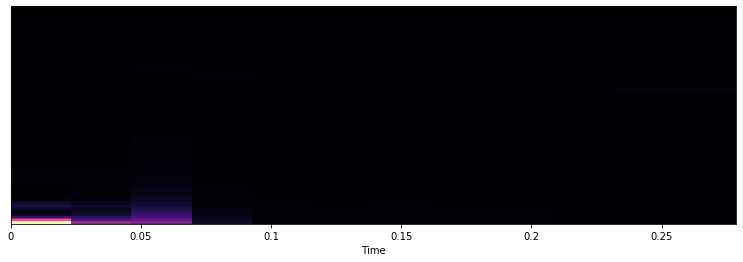

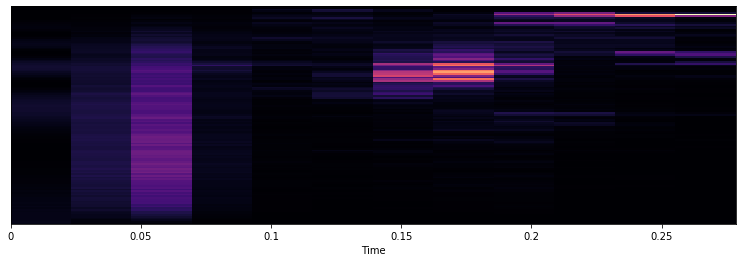

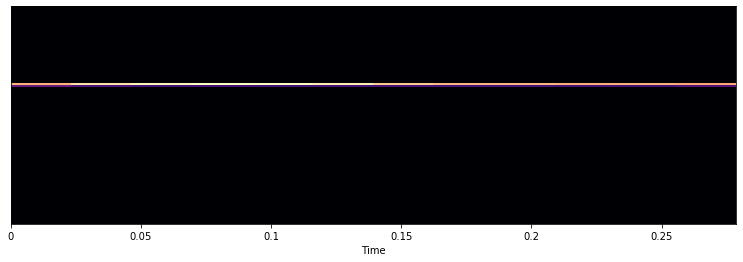

In [11]:
### EXEMPLE OF TRANSFORMED SAMPLE (6 DIFFERENT PRESSURE SIGNALS) ###

for i in range(len(data)):
    plt.figure(figsize=(13, 4))
    librosa.display.specshow(df_spectre[20][:,:,i], x_axis='time')

In [12]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df_spectre, y, random_state = 42, test_size=0.2)

In [13]:
### DEFINE CRNN ###

def get_model(data):
    
    inp = Input(shape=(data.shape[1], data.shape[2], data.shape[3]))
    
    x = Conv2D(filters = 64, kernel_size=(2, 2), padding='same')(inp)
    
    x = Permute((2, 3, 1))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Permute((3, 1, 2))(x)
    # equal to BatchNormalization(axis=1)
    
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Dropout(0.2)(x)
    
    x = Permute((2, 3, 1))(x)
    x = Reshape((data.shape[2], 64*64))(x)

    x = Bidirectional(GRU(64, activation='relu', return_sequences=False))(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(y_train.shape[1], activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:
model = get_model(X_train)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 12, 6)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 12, 64)       1600      
_________________________________________________________________
permute (Permute)            (None, 12, 64, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 64, 128)       512       
_________________________________________________________________
permute_1 (Permute)          (None, 128, 12, 64)       0         
_________________________________________________________________
activation (Activation)      (None, 128, 12, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 12, 64)        0     

In [15]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=15)

model = get_model(X_train)
model.fit(X_train, y_train, epochs=100, batch_size=256, verbose=2, validation_split=0.1, callbacks=[es])

Train on 1587 samples, validate on 177 samples
Epoch 1/100
1587/1587 - 22s - loss: 1.4619 - accuracy: 0.3497 - val_loss: 1.4336 - val_accuracy: 0.4746
Epoch 2/100
1587/1587 - 16s - loss: 1.1787 - accuracy: 0.4896 - val_loss: 1.3208 - val_accuracy: 0.4802
Epoch 3/100
1587/1587 - 16s - loss: 1.0277 - accuracy: 0.5570 - val_loss: 1.1614 - val_accuracy: 0.5650
Epoch 4/100
1587/1587 - 15s - loss: 0.9755 - accuracy: 0.5734 - val_loss: 1.0022 - val_accuracy: 0.5989
Epoch 5/100
1587/1587 - 15s - loss: 0.8743 - accuracy: 0.6257 - val_loss: 0.9196 - val_accuracy: 0.6158
Epoch 6/100
1587/1587 - 15s - loss: 0.8056 - accuracy: 0.6553 - val_loss: 0.9013 - val_accuracy: 0.6384
Epoch 7/100
1587/1587 - 15s - loss: 0.7594 - accuracy: 0.6755 - val_loss: 0.8338 - val_accuracy: 0.6441
Epoch 8/100
1587/1587 - 15s - loss: 0.7150 - accuracy: 0.6912 - val_loss: 0.7993 - val_accuracy: 0.6836
Epoch 9/100
1587/1587 - 15s - loss: 0.6378 - accuracy: 0.7429 - val_loss: 0.8388 - val_accuracy: 0.6497
Epoch 10/100
1587

In [16]:
### GET PREDICTED CLASS ###

pred_test = np.argmax(model.predict(X_test), axis=1)

In [17]:
print(classification_report([diz_reverse_label[np.argmax(label)] for label in y_test], 
                            [diz_reverse_label[label] for label in pred_test]))

              precision    recall  f1-score   support

          90       0.93      0.91      0.92       152
         100       0.75      0.63      0.68        75
         115       0.72      0.88      0.79        91
         130       0.97      0.92      0.94       123

    accuracy                           0.86       441
   macro avg       0.84      0.83      0.83       441
weighted avg       0.86      0.86      0.86       441



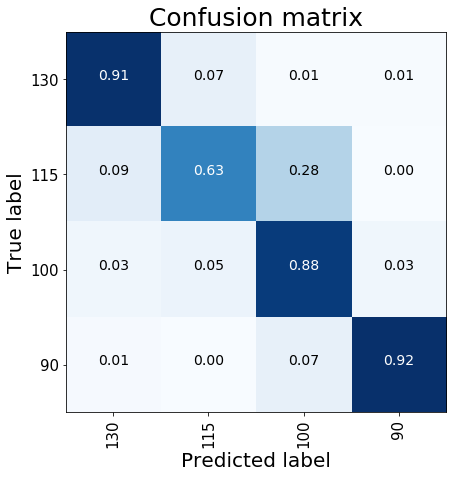

In [18]:
cnf_matrix = confusion_matrix([diz_reverse_label[np.argmax(label)] for label in y_test], 
                              [diz_reverse_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_reverse_label.values()))
plt.show()